## hw03
调通人脸检测代码，并与facedetails融合，输出面部指令。  
对编程不熟悉的学员也可以写自己对强化学习求解示例那幅图的理解。

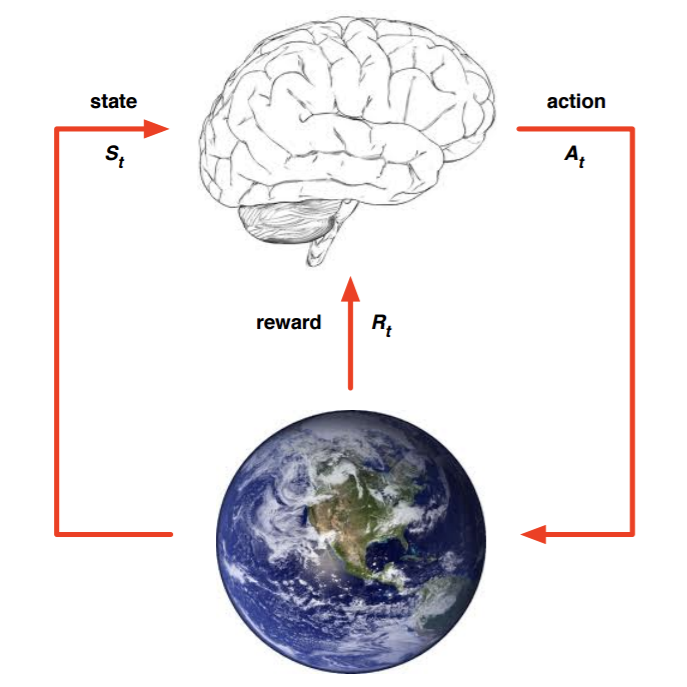

对编程不熟悉的学员也可以写自己对强化学习求解示例那幅图的理解。
* 地球代表环境，大脑代表策略，大脑以当前环境所处的状态，执行一个动作序列，环境会根据大脑给出的动作给出reward，同时改变所处的状态；
* 大脑会根据状态的改变和得到的reward调整策略，生成新的action